In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'masoudnickparvar/brain-tumor-mri-dataset'

100% 149M/149M [00:05<00:00, 32.9MB/s]
100% 149M/149M [00:05<00:00, 26.8MB/s]


In [ ]:
!unzip /content/brain-tumor-mri-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy
from keras.applications import VGG16

import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import legacy

In [ ]:
NOISE_DIM = 100
BATCH_SIZE = 32
STEPS_PER_EPOCH = 500
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = legacy.Adam(0.0002, 0.5)

In [ ]:
DIR_1 = "/content/Training/glioma"
DIR_2 = "/content/Training/meningioma"
DIR_3 = "/content/Training/notumor"
DIR_4 = "/content/Training/pituitary"


In [ ]:
def load_images(folder):

    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue

    imgs = np.array(imgs)
    labels = np.array(labels)

    return imgs, labels

In [ ]:
g_data, g_labels = load_images(DIR_1)
g_data.shape, g_labels.shape

((1321, 128, 128), (1321,))

In [ ]:
m_data,m_labels = load_images(DIR_2)
m_data.shape, m_labels.shape

((1339, 128, 128), (1339,))

In [ ]:
n_data,n_labels = load_images(DIR_3)
n_data.shape, n_labels.shape

((1595, 128, 128), (1595,))

In [ ]:
p_data, p_labels = load_images(DIR_4)
p_data.shape, p_labels.shape

((1457, 128, 128), (1457,))

In [ ]:
# glioma dataset
np.random.seed(SEED)
idxs_glioma = np.random.randint(0,1321,300)

#meningioma dataset
idxs_meningioma = np.random.randint(0,1339,300)

#notumor dataset
idxs_notumor = np.random.randint(0,1595,300)

#pituitary dataset
idxs_pituitary = np.random.randint(0,1457,350)

In [ ]:
X_train_glioma = g_data[idxs_glioma]
X_train_glioma.shape

(300, 128, 128)

In [ ]:
X_train_meningioma = m_data[idxs_meningioma]
X_train_meningioma.shape

(300, 128, 128)

In [ ]:
X_train_notumor = n_data[idxs_notumor]
X_train_notumor.shape

(300, 128, 128)

In [ ]:
X_train_pituitary = p_data[idxs_pituitary]
X_train_pituitary.shape

(350, 128, 128)

In [ ]:
# Normalize the Images
X_train_glioma = (X_train_glioma.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train_glioma = X_train_glioma.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train_glioma.shape

(300, 128, 128, 1)

In [ ]:
# Normalize the Images
X_train_meningioma = (X_train_meningioma.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train_meningioma = X_train_meningioma.reshape(-1, WIDTH,HEIGHT,CHANNELS)


# Check shape
X_train_meningioma.shape

(300, 128, 128, 1)

In [ ]:
# Normalize the Images
X_train_notumor = (X_train_notumor.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train_notumor = X_train_notumor.reshape(-1, WIDTH,HEIGHT,CHANNELS)


# Check shape
X_train_notumor.shape

(300, 128, 128, 1)

In [ ]:
# Normalize the Images
X_train_pituitary = (X_train_pituitary.astype(np.float32) - 127.5) / 127.5

# Reshape images
X_train_pituitary = X_train_pituitary.reshape(-1, WIDTH,HEIGHT,CHANNELS)


# Check shape
X_train_pituitary.shape

(350, 128, 128, 1)

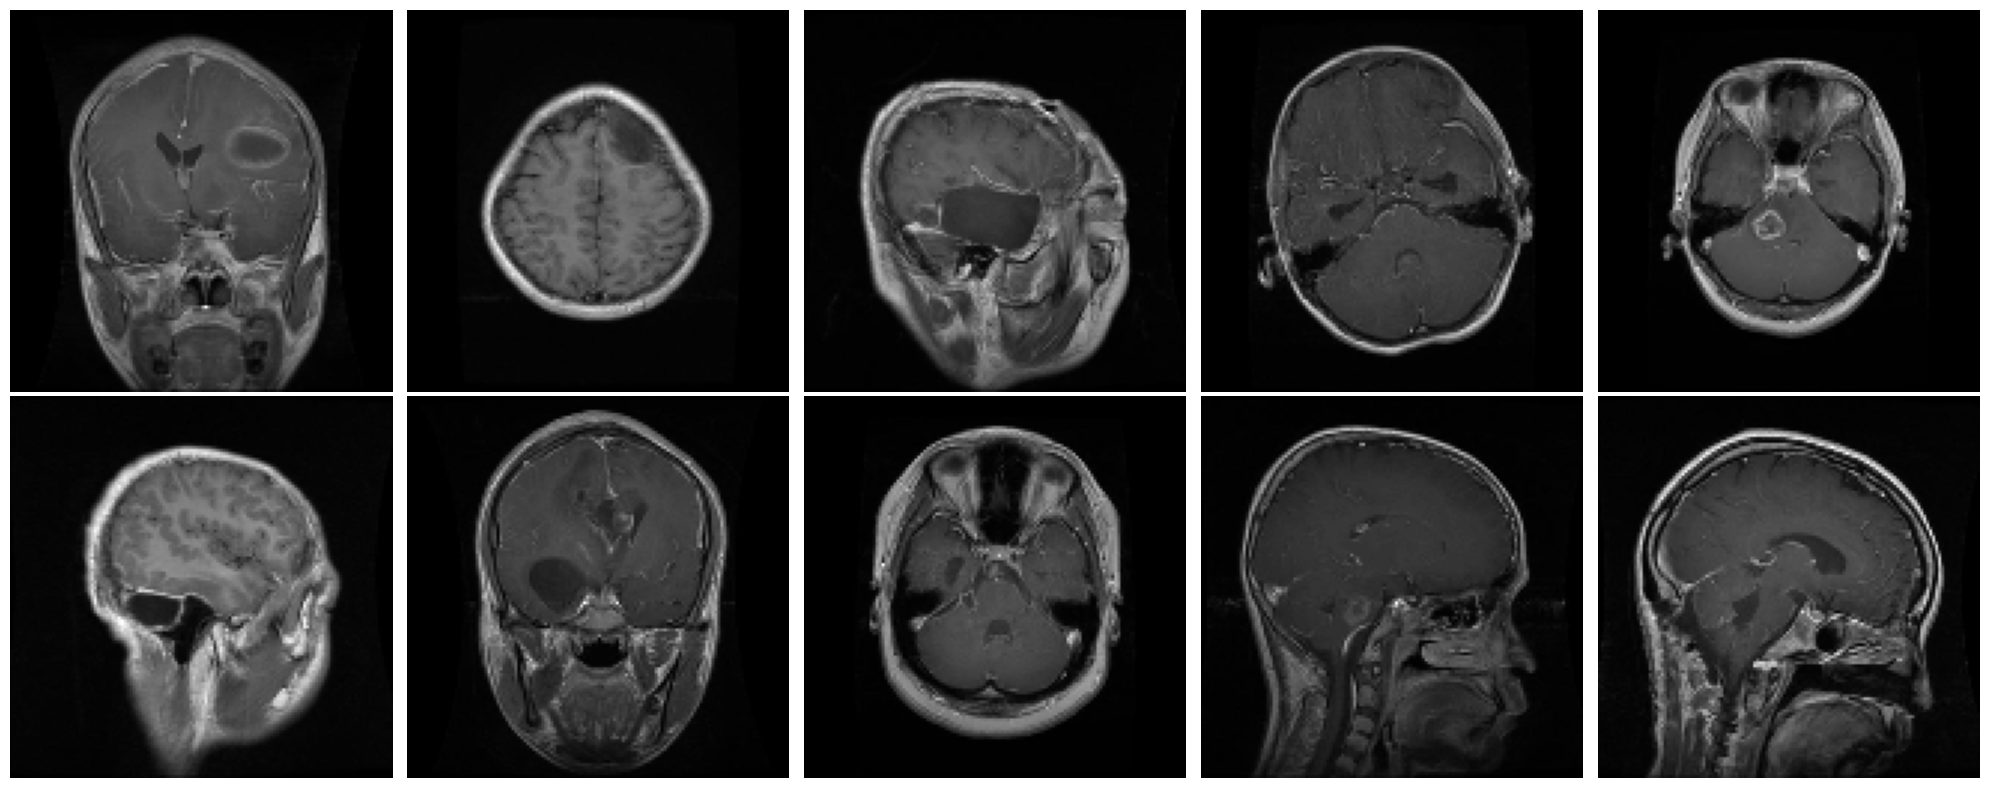

In [ ]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train_glioma[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [ ]:
def create_generator():

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ],
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model



In [ ]:
def create_discriminator():

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [ ]:
import tensorflow as tf
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate, LeakyReLU, Dropout
from keras.models import Sequential, Model
from keras.optimizers import Adam

def create_cgan():
    # Define the input layers
    noise = Input(shape=(NOISE_DIM,))
    labels = Input(shape=(1,))

    # Concatenate the noise and labels
    x = Concatenate()([noise, labels])

    # Define the generator architecture
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(np.prod(img_shape), activation='tanh')(x)
    x = Reshape(img_shape)(x)

    # Define the generator model
    generator = Model(inputs=[noise, labels], outputs=x)

    # Define the discriminator architecture
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    # Define the discriminator model
    discriminator = Model(inputs=inputs, outputs=x)

    # Define the GAN model
    gan_input = Input(shape=(NOISE_DIM + 1,))
    gan_output = discriminator(generator(gan_input))
    gan = Model(inputs=gan_input, outputs=gan_output)

    # Compile the models
    optimizer = Adam(lr=0.0002, beta_1=0.5)
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)

    return generator, discriminator, gan

In [ ]:
print('\n')
discriminator = create_discriminator()
print('\n')
generator = create_generator()

discriminator.trainable = False

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)   

In [ ]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)

    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')

        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
np.random.seed(SEED)
for epoch in range(EPOCHS):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)

        idx = np.random.randint(0, X_train_meningioma.shape[0], size=BATCH_SIZE)
        real_X = X_train_meningioma[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)

        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    # noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    # sample_images(noise, (2,5))

  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  0%|          | 1/500 [00:32<4:31:17, 32.62s/it]

1/1 [==============================] - 5s 5s/step


  0%|          | 2/500 [00:58<3:58:31, 28.74s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 3/500 [01:19<3:29:22, 25.28s/it]

1/1 [==============================] - 3s 3s/step


  1%|          | 4/500 [01:43<3:23:00, 24.56s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 5/500 [02:05<3:16:52, 23.86s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 6/500 [02:28<3:12:36, 23.39s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 7/500 [02:50<3:07:32, 22.82s/it]

1/1 [==============================] - 3s 3s/step


  2%|▏         | 8/500 [03:13<3:08:55, 23.04s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 9/500 [03:35<3:05:34, 22.68s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 10/500 [03:57<3:03:48, 22.51s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 11/500 [04:18<2:59:45, 22.06s/it]

1/1 [==============================] - 3s 3s/step


  2%|▏         | 12/500 [04:41<3:02:31, 22.44s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 13/500 [05:03<3:00:53, 22.29s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 14/500 [05:25<3:00:04, 22.23s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 15/500 [05:47<2:58:06, 22.03s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 16/500 [06:09<2:56:55, 21.93s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 17/500 [06:31<2:58:38, 22.19s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 18/500 [06:53<2:57:25, 22.09s/it]

1/1 [==============================] - 3s 3s/step


  4%|▍         | 19/500 [07:18<3:03:02, 22.83s/it]

1/1 [==============================] - 3s 3s/step


  4%|▍         | 20/500 [07:39<2:58:42, 22.34s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 21/500 [08:01<2:57:58, 22.29s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 22/500 [08:24<2:57:39, 22.30s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 23/500 [08:45<2:54:57, 22.01s/it]

1/1 [==============================] - 3s 3s/step


  5%|▍         | 24/500 [09:07<2:54:20, 21.98s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 25/500 [09:29<2:54:38, 22.06s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 26/500 [09:51<2:53:09, 21.92s/it]

1/1 [==============================] - 3s 3s/step


  5%|▌         | 27/500 [10:12<2:51:00, 21.69s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 28/500 [10:36<2:56:28, 22.43s/it]

1/1 [==============================] - 5s 5s/step


  6%|▌         | 29/500 [11:03<3:07:56, 23.94s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 30/500 [11:26<3:03:12, 23.39s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 31/500 [11:47<2:58:23, 22.82s/it]

1/1 [==============================] - 3s 3s/step


  6%|▋         | 32/500 [12:08<2:54:23, 22.36s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 33/500 [12:30<2:52:54, 22.21s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 34/500 [12:52<2:52:05, 22.16s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 35/500 [13:13<2:49:19, 21.85s/it]

1/1 [==============================] - 3s 3s/step


  7%|▋         | 36/500 [13:35<2:49:09, 21.87s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 37/500 [13:57<2:49:08, 21.92s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 38/500 [14:18<2:46:56, 21.68s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 39/500 [14:42<2:51:24, 22.31s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 40/500 [15:06<2:53:23, 22.62s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 41/500 [15:27<2:51:26, 22.41s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 42/500 [15:50<2:50:19, 22.31s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 43/500 [16:11<2:46:59, 21.92s/it]

1/1 [==============================] - 3s 3s/step


  9%|▉         | 44/500 [16:32<2:46:11, 21.87s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 45/500 [16:54<2:46:28, 21.95s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 46/500 [17:16<2:44:14, 21.71s/it]

1/1 [==============================] - 3s 3s/step


  9%|▉         | 47/500 [17:37<2:43:08, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 48/500 [17:59<2:43:34, 21.71s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 49/500 [18:21<2:43:06, 21.70s/it]

1/1 [==============================] - 3s 3s/step


 10%|█         | 50/500 [18:42<2:41:02, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 51/500 [19:04<2:41:59, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 52/500 [19:26<2:43:12, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 53/500 [19:47<2:41:22, 21.66s/it]

1/1 [==============================] - 3s 3s/step


 11%|█         | 54/500 [20:09<2:40:42, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 55/500 [20:31<2:41:24, 21.76s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 56/500 [20:57<2:50:19, 23.02s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 57/500 [21:19<2:47:32, 22.69s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▏        | 58/500 [21:40<2:44:04, 22.27s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 59/500 [22:02<2:43:29, 22.24s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 60/500 [22:24<2:42:56, 22.22s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 61/500 [22:45<2:40:17, 21.91s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▏        | 62/500 [23:07<2:39:53, 21.90s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 63/500 [23:30<2:40:18, 22.01s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 64/500 [23:51<2:38:52, 21.86s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 65/500 [24:13<2:37:28, 21.72s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 66/500 [24:34<2:37:39, 21.80s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 67/500 [24:56<2:37:38, 21.84s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▎        | 68/500 [25:17<2:35:21, 21.58s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 69/500 [25:39<2:35:53, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 70/500 [26:02<2:36:28, 21.83s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 71/500 [26:23<2:35:07, 21.70s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 72/500 [26:45<2:34:35, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 73/500 [27:06<2:34:49, 21.76s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 74/500 [27:28<2:34:38, 21.78s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 75/500 [27:49<2:32:31, 21.53s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 76/500 [28:11<2:33:11, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 77/500 [28:34<2:34:07, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 78/500 [28:55<2:32:31, 21.69s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 79/500 [29:17<2:32:11, 21.69s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 80/500 [29:39<2:32:27, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 81/500 [30:00<2:32:18, 21.81s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▋        | 82/500 [30:25<2:37:35, 22.62s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 83/500 [30:46<2:34:17, 22.20s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 84/500 [31:15<2:48:05, 24.24s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 85/500 [31:38<2:43:48, 23.68s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 86/500 [32:00<2:40:40, 23.29s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 87/500 [32:27<2:48:16, 24.45s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 88/500 [32:49<2:43:37, 23.83s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 89/500 [33:11<2:37:40, 23.02s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 90/500 [33:34<2:37:57, 23.12s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 91/500 [33:56<2:35:00, 22.74s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 92/500 [34:18<2:33:30, 22.57s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 93/500 [34:39<2:30:32, 22.19s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 94/500 [35:01<2:29:03, 22.03s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 95/500 [35:23<2:28:29, 22.00s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 96/500 [35:45<2:28:41, 22.08s/it]

1/1 [==============================] - 3s 3s/step


 19%|█▉        | 97/500 [36:06<2:25:56, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 98/500 [36:28<2:25:52, 21.77s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 99/500 [36:50<2:26:15, 21.88s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 100/500 [37:11<2:24:09, 21.62s/it]

1/1 [==============================] - 3s 3s/step


 20%|██        | 101/500 [37:34<2:27:15, 22.14s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 102/500 [37:56<2:26:16, 22.05s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 103/500 [38:18<2:25:43, 22.02s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 104/500 [38:39<2:23:00, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 105/500 [39:01<2:22:59, 21.72s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 106/500 [39:23<2:23:06, 21.79s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 107/500 [39:44<2:21:13, 21.56s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 108/500 [40:06<2:21:08, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 109/500 [40:28<2:21:45, 21.75s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 110/500 [40:49<2:19:59, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 111/500 [41:10<2:19:10, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 112/500 [41:32<2:19:24, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 113/500 [41:53<2:18:56, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 114/500 [42:14<2:17:31, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 115/500 [42:36<2:18:33, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 116/500 [42:59<2:19:23, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 117/500 [43:19<2:17:17, 21.51s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▎       | 118/500 [43:41<2:17:26, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 119/500 [44:03<2:17:54, 21.72s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 120/500 [44:25<2:17:12, 21.66s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 121/500 [44:46<2:16:03, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 122/500 [45:08<2:16:24, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 123/500 [45:29<2:15:43, 21.60s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▍       | 124/500 [45:50<2:14:11, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 125/500 [46:12<2:14:46, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 126/500 [46:34<2:15:09, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 127/500 [46:55<2:13:25, 21.46s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 128/500 [47:17<2:13:57, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 129/500 [47:39<2:14:35, 21.77s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 130/500 [48:00<2:13:03, 21.58s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 131/500 [48:22<2:12:51, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▋       | 132/500 [48:44<2:12:57, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 133/500 [49:06<2:12:33, 21.67s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 134/500 [49:26<2:10:35, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 135/500 [49:48<2:11:04, 21.55s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 136/500 [50:10<2:11:09, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 137/500 [50:31<2:09:44, 21.45s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 138/500 [50:53<2:10:12, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 139/500 [51:15<2:10:50, 21.75s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 140/500 [51:36<2:09:13, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 141/500 [51:58<2:09:07, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 142/500 [52:20<2:09:54, 21.77s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 143/500 [52:42<2:08:53, 21.66s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 144/500 [53:05<2:12:34, 22.34s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 145/500 [53:27<2:10:43, 22.09s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 146/500 [53:49<2:10:08, 22.06s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 147/500 [54:11<2:08:55, 21.91s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 148/500 [54:32<2:06:58, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 149/500 [54:53<2:07:04, 21.72s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 150/500 [55:15<2:07:03, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 151/500 [55:36<2:05:04, 21.50s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 152/500 [55:58<2:05:30, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 153/500 [56:20<2:05:58, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 154/500 [56:41<2:04:22, 21.57s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 155/500 [57:03<2:03:56, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 156/500 [57:25<2:03:54, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 157/500 [57:46<2:03:32, 21.61s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 158/500 [58:07<2:02:14, 21.44s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 159/500 [58:29<2:02:42, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 160/500 [58:51<2:03:18, 21.76s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 161/500 [59:12<2:01:26, 21.49s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 162/500 [59:34<2:00:59, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 163/500 [59:56<2:01:17, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 164/500 [1:00:17<2:00:30, 21.52s/it]

1/1 [==============================] - 3s 3s/step


 33%|███▎      | 165/500 [1:00:41<2:04:12, 22.25s/it]

1/1 [==============================] - 3s 3s/step


 33%|███▎      | 166/500 [1:01:02<2:02:34, 22.02s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 167/500 [1:01:24<2:02:01, 21.99s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▎      | 168/500 [1:01:46<2:01:25, 21.94s/it]

1/1 [==============================] - 3s 3s/step


 34%|███▍      | 169/500 [1:02:07<1:59:28, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 170/500 [1:02:29<1:59:36, 21.75s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 171/500 [1:02:51<1:59:46, 21.84s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 172/500 [1:03:12<1:58:17, 21.64s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▍      | 173/500 [1:03:34<1:58:02, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 174/500 [1:03:56<1:58:25, 21.80s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 175/500 [1:04:17<1:57:16, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▌      | 176/500 [1:04:39<1:56:28, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 177/500 [1:05:01<1:56:50, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 178/500 [1:05:23<1:56:38, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 179/500 [1:05:44<1:54:58, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 180/500 [1:06:05<1:55:18, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 181/500 [1:06:28<1:56:13, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 182/500 [1:06:49<1:54:36, 21.62s/it]

1/1 [==============================] - 3s 3s/step


 37%|███▋      | 183/500 [1:07:12<1:57:17, 22.20s/it]

1/1 [==============================] - 3s 3s/step


 37%|███▋      | 184/500 [1:07:34<1:56:09, 22.05s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 185/500 [1:07:56<1:55:48, 22.06s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 186/500 [1:08:17<1:53:43, 21.73s/it]

1/1 [==============================] - 3s 3s/step


 37%|███▋      | 187/500 [1:08:39<1:52:54, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 188/500 [1:09:01<1:52:54, 21.71s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 189/500 [1:09:22<1:51:33, 21.52s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 190/500 [1:09:43<1:50:46, 21.44s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 191/500 [1:10:05<1:50:49, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 192/500 [1:10:26<1:50:23, 21.50s/it]

1/1 [==============================] - 3s 3s/step


 39%|███▊      | 193/500 [1:10:47<1:48:59, 21.30s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 194/500 [1:11:09<1:49:13, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 195/500 [1:11:30<1:49:26, 21.53s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 196/500 [1:11:51<1:47:53, 21.29s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 197/500 [1:12:13<1:48:18, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 198/500 [1:12:35<1:48:59, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 199/500 [1:12:56<1:47:31, 21.43s/it]

1/1 [==============================] - 3s 3s/step


 40%|████      | 200/500 [1:13:17<1:47:13, 21.44s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 201/500 [1:13:39<1:47:21, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 202/500 [1:14:00<1:46:14, 21.39s/it]

1/1 [==============================] - 3s 3s/step


 41%|████      | 203/500 [1:14:22<1:45:52, 21.39s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 204/500 [1:14:43<1:46:00, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 205/500 [1:15:05<1:45:40, 21.49s/it]

1/1 [==============================] - 3s 3s/step


 41%|████      | 206/500 [1:15:26<1:44:31, 21.33s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 207/500 [1:15:48<1:44:55, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 208/500 [1:16:09<1:44:40, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 209/500 [1:16:30<1:43:25, 21.32s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 210/500 [1:16:52<1:43:43, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 211/500 [1:17:14<1:44:16, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 212/500 [1:17:35<1:42:58, 21.45s/it]

1/1 [==============================] - 3s 3s/step


 43%|████▎     | 213/500 [1:17:56<1:42:24, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 214/500 [1:18:18<1:42:49, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 215/500 [1:18:40<1:42:24, 21.56s/it]

1/1 [==============================] - 3s 3s/step


 43%|████▎     | 216/500 [1:19:01<1:41:10, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 217/500 [1:19:22<1:41:18, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 218/500 [1:19:44<1:41:28, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 219/500 [1:20:05<1:39:55, 21.34s/it]

1/1 [==============================] - 3s 3s/step


 44%|████▍     | 220/500 [1:20:27<1:40:14, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 221/500 [1:20:49<1:40:26, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 222/500 [1:21:10<1:39:09, 21.40s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▍     | 223/500 [1:21:31<1:39:08, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 224/500 [1:21:53<1:39:27, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 225/500 [1:22:14<1:38:17, 21.45s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▌     | 226/500 [1:22:36<1:37:56, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 227/500 [1:22:57<1:37:52, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 228/500 [1:23:19<1:38:07, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 46%|████▌     | 229/500 [1:23:40<1:36:43, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 230/500 [1:24:02<1:36:53, 21.53s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 231/500 [1:24:24<1:37:04, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 232/500 [1:24:45<1:35:36, 21.41s/it]

1/1 [==============================] - 3s 3s/step


 47%|████▋     | 233/500 [1:25:07<1:35:42, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 234/500 [1:25:29<1:36:04, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 235/500 [1:25:50<1:34:53, 21.49s/it]

1/1 [==============================] - 3s 3s/step


 47%|████▋     | 236/500 [1:26:11<1:34:30, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 237/500 [1:26:33<1:34:39, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 238/500 [1:26:55<1:34:30, 21.64s/it]

1/1 [==============================] - 3s 3s/step


 48%|████▊     | 239/500 [1:27:16<1:33:06, 21.40s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 240/500 [1:27:37<1:32:59, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 241/500 [1:27:59<1:33:27, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 242/500 [1:28:20<1:31:55, 21.38s/it]

1/1 [==============================] - 3s 3s/step


 49%|████▊     | 243/500 [1:28:42<1:31:54, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 244/500 [1:29:04<1:32:07, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 245/500 [1:29:24<1:30:52, 21.38s/it]

1/1 [==============================] - 3s 3s/step


 49%|████▉     | 246/500 [1:29:46<1:30:53, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 247/500 [1:30:13<1:37:13, 23.06s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 248/500 [1:30:35<1:35:20, 22.70s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 249/500 [1:30:56<1:33:26, 22.34s/it]

1/1 [==============================] - 3s 3s/step


 50%|█████     | 250/500 [1:31:18<1:31:46, 22.03s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 251/500 [1:31:39<1:31:15, 21.99s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 252/500 [1:32:01<1:30:55, 22.00s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 253/500 [1:32:22<1:29:15, 21.68s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████     | 254/500 [1:32:44<1:28:58, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 255/500 [1:33:06<1:29:13, 21.85s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 256/500 [1:33:28<1:28:04, 21.66s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████▏    | 257/500 [1:33:49<1:27:24, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 258/500 [1:34:11<1:27:23, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 259/500 [1:34:33<1:27:14, 21.72s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 260/500 [1:34:54<1:25:51, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 261/500 [1:35:15<1:25:59, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 262/500 [1:35:38<1:26:24, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 263/500 [1:35:59<1:25:15, 21.58s/it]

1/1 [==============================] - 3s 3s/step


 53%|█████▎    | 264/500 [1:36:22<1:27:21, 22.21s/it]

1/1 [==============================] - 3s 3s/step


 53%|█████▎    | 265/500 [1:36:44<1:26:31, 22.09s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 266/500 [1:37:06<1:26:15, 22.12s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 267/500 [1:37:27<1:24:33, 21.77s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▎    | 268/500 [1:37:49<1:23:55, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 269/500 [1:38:11<1:23:45, 21.75s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 270/500 [1:38:33<1:23:17, 21.73s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▍    | 271/500 [1:38:53<1:22:00, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 272/500 [1:39:15<1:21:57, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 273/500 [1:39:37<1:21:57, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 274/500 [1:39:58<1:20:42, 21.43s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████▌    | 275/500 [1:40:21<1:22:24, 21.98s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 276/500 [1:40:43<1:21:51, 21.93s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 277/500 [1:41:05<1:21:45, 22.00s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 278/500 [1:41:26<1:20:15, 21.69s/it]

1/1 [==============================] - 3s 3s/step


 56%|█████▌    | 279/500 [1:41:48<1:19:51, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 280/500 [1:42:10<1:19:43, 21.74s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 281/500 [1:42:31<1:19:02, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 56%|█████▋    | 282/500 [1:42:52<1:18:02, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 283/500 [1:43:14<1:18:00, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 284/500 [1:43:36<1:17:41, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 285/500 [1:43:57<1:16:40, 21.40s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 286/500 [1:44:18<1:16:43, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 287/500 [1:44:41<1:17:06, 21.72s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 288/500 [1:45:01<1:15:53, 21.48s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████▊    | 289/500 [1:45:23<1:15:27, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 290/500 [1:45:45<1:15:35, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 291/500 [1:46:06<1:14:33, 21.40s/it]

1/1 [==============================] - 3s 3s/step


 58%|█████▊    | 292/500 [1:46:27<1:14:04, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▊    | 293/500 [1:46:49<1:14:13, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 294/500 [1:47:10<1:13:53, 21.52s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████▉    | 295/500 [1:47:31<1:12:43, 21.29s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 296/500 [1:47:53<1:12:49, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 297/500 [1:48:20<1:18:16, 23.14s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 298/500 [1:48:42<1:16:53, 22.84s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 299/500 [1:49:03<1:14:40, 22.29s/it]

1/1 [==============================] - 3s 3s/step


 60%|██████    | 300/500 [1:49:25<1:13:20, 22.00s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 301/500 [1:49:46<1:12:49, 21.96s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 302/500 [1:50:08<1:11:57, 21.81s/it]

1/1 [==============================] - 3s 3s/step


 61%|██████    | 303/500 [1:50:29<1:10:52, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 304/500 [1:50:51<1:10:47, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 305/500 [1:51:13<1:10:48, 21.79s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 306/500 [1:51:34<1:09:32, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 307/500 [1:51:56<1:09:33, 21.63s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 308/500 [1:52:18<1:09:43, 21.79s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 309/500 [1:52:39<1:08:40, 21.58s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 310/500 [1:53:00<1:08:11, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 311/500 [1:53:22<1:08:04, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 312/500 [1:53:44<1:07:39, 21.60s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████▎   | 313/500 [1:54:05<1:07:29, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████▎   | 314/500 [1:54:29<1:08:31, 22.10s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████▎   | 315/500 [1:54:52<1:09:12, 22.45s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 316/500 [1:55:14<1:09:00, 22.50s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████▎   | 317/500 [1:55:36<1:07:37, 22.17s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 318/500 [1:55:59<1:08:09, 22.47s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 319/500 [1:56:26<1:12:18, 23.97s/it]

1/1 [==============================] - 3s 3s/step


 64%|██████▍   | 320/500 [1:56:50<1:11:15, 23.75s/it]

1/1 [==============================] - 3s 3s/step


 64%|██████▍   | 321/500 [1:57:13<1:10:22, 23.59s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 322/500 [1:57:35<1:08:48, 23.19s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▍   | 323/500 [1:57:58<1:07:43, 22.96s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 324/500 [1:58:20<1:07:00, 22.85s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 325/500 [1:58:43<1:06:44, 22.88s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▌   | 326/500 [1:59:05<1:05:29, 22.59s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▌   | 327/500 [1:59:28<1:05:17, 22.65s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 328/500 [1:59:51<1:05:00, 22.68s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 329/500 [2:00:12<1:03:48, 22.39s/it]

1/1 [==============================] - 3s 3s/step


 66%|██████▌   | 330/500 [2:00:34<1:02:33, 22.08s/it]

1/1 [==============================] - 2s 2s/step


 66%|██████▌   | 331/500 [2:00:57<1:03:16, 22.46s/it]

1/1 [==============================] - 3s 3s/step


 66%|██████▋   | 332/500 [2:01:20<1:03:36, 22.72s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 333/500 [2:01:42<1:02:37, 22.50s/it]

1/1 [==============================] - 3s 3s/step


 67%|██████▋   | 334/500 [2:02:07<1:03:55, 23.11s/it]

1/1 [==============================] - 3s 3s/step


 67%|██████▋   | 335/500 [2:02:29<1:02:59, 22.91s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 336/500 [2:02:52<1:02:47, 22.97s/it]

1/1 [==============================] - 2s 2s/step


 67%|██████▋   | 337/500 [2:03:15<1:02:22, 22.96s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 338/500 [2:03:37<1:01:14, 22.68s/it]

1/1 [==============================] - 3s 3s/step


 68%|██████▊   | 339/500 [2:03:59<1:00:07, 22.41s/it]

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 340/500 [2:04:22<1:00:17, 22.61s/it]

1/1 [==============================] - 3s 3s/step


 68%|██████▊   | 341/500 [2:04:44<59:36, 22.49s/it]  

1/1 [==============================] - 2s 2s/step


 68%|██████▊   | 342/500 [2:05:06<58:26, 22.20s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▊   | 343/500 [2:05:28<58:15, 22.26s/it]

1/1 [==============================] - 2s 2s/step


 69%|██████▉   | 344/500 [2:05:51<58:30, 22.50s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▉   | 345/500 [2:06:13<57:45, 22.36s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▉   | 346/500 [2:06:38<59:16, 23.09s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▉   | 347/500 [2:07:03<59:53, 23.49s/it]

1/1 [==============================] - 3s 3s/step


 70%|██████▉   | 348/500 [2:07:27<59:59, 23.68s/it]

1/1 [==============================] - 2s 2s/step


 70%|██████▉   | 349/500 [2:07:50<59:05, 23.48s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 350/500 [2:08:12<57:38, 23.06s/it]

1/1 [==============================] - 2s 2s/step


 70%|███████   | 351/500 [2:08:33<55:45, 22.45s/it]

1/1 [==============================] - 3s 3s/step


 70%|███████   | 352/500 [2:08:54<54:42, 22.18s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 353/500 [2:09:16<54:03, 22.07s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 354/500 [2:09:38<53:18, 21.90s/it]

1/1 [==============================] - 3s 3s/step


 71%|███████   | 355/500 [2:09:59<52:18, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████   | 356/500 [2:10:21<52:08, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 71%|███████▏  | 357/500 [2:10:43<51:50, 21.75s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 358/500 [2:11:04<50:54, 21.51s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████▏  | 359/500 [2:11:25<50:48, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 360/500 [2:11:48<50:47, 21.77s/it]

1/1 [==============================] - 2s 2s/step


 72%|███████▏  | 361/500 [2:12:09<49:57, 21.56s/it]

1/1 [==============================] - 3s 3s/step


 72%|███████▏  | 362/500 [2:12:30<49:30, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 363/500 [2:12:52<49:17, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 364/500 [2:13:13<48:42, 21.49s/it]

1/1 [==============================] - 3s 3s/step


 73%|███████▎  | 365/500 [2:13:34<48:08, 21.40s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 366/500 [2:13:56<48:10, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 73%|███████▎  | 367/500 [2:14:18<48:00, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▎  | 368/500 [2:14:39<47:12, 21.46s/it]

1/1 [==============================] - 3s 3s/step


 74%|███████▍  | 369/500 [2:15:02<48:02, 22.00s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 370/500 [2:15:24<47:29, 21.92s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 371/500 [2:15:46<47:09, 21.93s/it]

1/1 [==============================] - 2s 2s/step


 74%|███████▍  | 372/500 [2:16:07<46:07, 21.62s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▍  | 373/500 [2:16:30<46:53, 22.15s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▍  | 374/500 [2:16:52<46:23, 22.09s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 375/500 [2:17:14<45:54, 22.04s/it]

1/1 [==============================] - 2s 2s/step


 75%|███████▌  | 376/500 [2:17:35<44:55, 21.74s/it]

1/1 [==============================] - 3s 3s/step


 75%|███████▌  | 377/500 [2:17:57<44:48, 21.85s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 378/500 [2:18:20<44:46, 22.02s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 379/500 [2:18:41<44:00, 21.82s/it]

1/1 [==============================] - 3s 3s/step


 76%|███████▌  | 380/500 [2:19:03<43:27, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▌  | 381/500 [2:19:25<43:17, 21.83s/it]

1/1 [==============================] - 2s 2s/step


 76%|███████▋  | 382/500 [2:19:47<43:06, 21.92s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 383/500 [2:20:08<42:16, 21.68s/it]

1/1 [==============================] - 3s 3s/step


 77%|███████▋  | 384/500 [2:20:30<42:12, 21.84s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 385/500 [2:20:57<44:47, 23.37s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 386/500 [2:21:19<43:30, 22.90s/it]

1/1 [==============================] - 2s 2s/step


 77%|███████▋  | 387/500 [2:21:40<42:15, 22.44s/it]

1/1 [==============================] - 3s 3s/step


 78%|███████▊  | 388/500 [2:22:01<41:06, 22.02s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 389/500 [2:22:23<40:39, 21.98s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 390/500 [2:22:45<40:12, 21.93s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 391/500 [2:23:12<42:46, 23.54s/it]

1/1 [==============================] - 2s 2s/step


 78%|███████▊  | 392/500 [2:23:34<41:29, 23.06s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▊  | 393/500 [2:23:55<40:02, 22.45s/it]

1/1 [==============================] - 3s 3s/step


 79%|███████▉  | 394/500 [2:24:17<39:24, 22.31s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 395/500 [2:24:39<38:57, 22.27s/it]

1/1 [==============================] - 2s 2s/step


 79%|███████▉  | 396/500 [2:25:01<38:03, 21.96s/it]

1/1 [==============================] - 3s 3s/step


 79%|███████▉  | 397/500 [2:25:22<37:31, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 398/500 [2:25:44<37:18, 21.94s/it]

1/1 [==============================] - 2s 2s/step


 80%|███████▉  | 399/500 [2:26:06<37:01, 21.99s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 400/500 [2:26:28<36:15, 21.76s/it]

1/1 [==============================] - 3s 3s/step


 80%|████████  | 401/500 [2:26:50<36:04, 21.87s/it]

1/1 [==============================] - 2s 2s/step


 80%|████████  | 402/500 [2:27:12<35:54, 21.99s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 403/500 [2:27:33<35:10, 21.76s/it]

1/1 [==============================] - 3s 3s/step


 81%|████████  | 404/500 [2:27:55<34:39, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 405/500 [2:28:17<34:25, 21.74s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████  | 406/500 [2:28:39<34:17, 21.89s/it]

1/1 [==============================] - 2s 2s/step


 81%|████████▏ | 407/500 [2:29:00<33:32, 21.64s/it]

1/1 [==============================] - 3s 3s/step


 82%|████████▏ | 408/500 [2:29:22<33:20, 21.74s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 409/500 [2:29:44<33:08, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 410/500 [2:30:05<32:28, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 82%|████████▏ | 411/500 [2:30:27<32:04, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 82%|████████▏ | 412/500 [2:30:49<31:53, 21.74s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 413/500 [2:31:10<31:26, 21.68s/it]

1/1 [==============================] - 3s 3s/step


 83%|████████▎ | 414/500 [2:31:31<30:47, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 415/500 [2:31:53<30:37, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 416/500 [2:32:16<30:34, 21.84s/it]

1/1 [==============================] - 2s 2s/step


 83%|████████▎ | 417/500 [2:32:37<29:54, 21.62s/it]

1/1 [==============================] - 3s 3s/step


 84%|████████▎ | 418/500 [2:32:59<29:41, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 419/500 [2:33:21<29:30, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 420/500 [2:33:42<28:57, 21.71s/it]

1/1 [==============================] - 3s 3s/step


 84%|████████▍ | 421/500 [2:34:04<28:28, 21.63s/it]

1/1 [==============================] - 2s 2s/step


 84%|████████▍ | 422/500 [2:34:26<28:13, 21.71s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 423/500 [2:34:48<28:01, 21.83s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▍ | 424/500 [2:35:09<27:22, 21.61s/it]

1/1 [==============================] - 3s 3s/step


 85%|████████▌ | 425/500 [2:35:31<27:07, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 426/500 [2:35:53<26:56, 21.84s/it]

1/1 [==============================] - 2s 2s/step


 85%|████████▌ | 427/500 [2:36:14<26:24, 21.70s/it]

1/1 [==============================] - 3s 3s/step


 86%|████████▌ | 428/500 [2:36:38<26:48, 22.35s/it]

1/1 [==============================] - 3s 3s/step


 86%|████████▌ | 429/500 [2:37:00<26:10, 22.11s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 430/500 [2:37:22<25:43, 22.06s/it]

1/1 [==============================] - 2s 2s/step


 86%|████████▌ | 431/500 [2:37:43<25:05, 21.81s/it]

1/1 [==============================] - 3s 3s/step


 86%|████████▋ | 432/500 [2:38:04<24:32, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 433/500 [2:38:26<24:18, 21.76s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 434/500 [2:38:48<23:56, 21.77s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 435/500 [2:39:09<23:17, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 436/500 [2:39:31<23:03, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 87%|████████▋ | 437/500 [2:39:53<22:53, 21.80s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 438/500 [2:40:14<22:18, 21.58s/it]

1/1 [==============================] - 3s 3s/step


 88%|████████▊ | 439/500 [2:40:37<22:28, 22.11s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 440/500 [2:40:59<22:05, 22.10s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 441/500 [2:41:21<21:42, 22.08s/it]

1/1 [==============================] - 2s 2s/step


 88%|████████▊ | 442/500 [2:41:43<21:04, 21.81s/it]

1/1 [==============================] - 3s 3s/step


 89%|████████▊ | 443/500 [2:42:06<21:10, 22.28s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 444/500 [2:42:28<20:40, 22.15s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 445/500 [2:42:50<20:14, 22.09s/it]

1/1 [==============================] - 2s 2s/step


 89%|████████▉ | 446/500 [2:43:11<19:31, 21.70s/it]

1/1 [==============================] - 3s 3s/step


 89%|████████▉ | 447/500 [2:43:33<19:14, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 448/500 [2:43:55<18:56, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 90%|████████▉ | 449/500 [2:44:16<18:22, 21.63s/it]

1/1 [==============================] - 3s 3s/step


 90%|█████████ | 450/500 [2:44:39<18:26, 22.13s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 451/500 [2:45:01<18:01, 22.07s/it]

1/1 [==============================] - 2s 2s/step


 90%|█████████ | 452/500 [2:45:23<17:40, 22.09s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 453/500 [2:45:44<17:03, 21.78s/it]

1/1 [==============================] - 3s 3s/step


 91%|█████████ | 454/500 [2:46:06<16:37, 21.69s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 455/500 [2:46:32<17:21, 23.14s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████ | 456/500 [2:46:54<16:38, 22.70s/it]

1/1 [==============================] - 2s 2s/step


 91%|█████████▏| 457/500 [2:47:16<16:04, 22.43s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 458/500 [2:47:36<15:21, 21.93s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▏| 459/500 [2:47:58<14:57, 21.88s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 460/500 [2:48:20<14:37, 21.94s/it]

1/1 [==============================] - 2s 2s/step


 92%|█████████▏| 461/500 [2:48:41<14:04, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▏| 462/500 [2:49:03<13:40, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 463/500 [2:49:24<13:21, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 464/500 [2:49:46<12:55, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 93%|█████████▎| 465/500 [2:50:07<12:29, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 466/500 [2:50:29<12:11, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 93%|█████████▎| 467/500 [2:50:50<11:51, 21.55s/it]

1/1 [==============================] - 3s 3s/step


 94%|█████████▎| 468/500 [2:51:11<11:23, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 469/500 [2:51:33<11:07, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 470/500 [2:51:55<10:49, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 94%|█████████▍| 471/500 [2:52:16<10:21, 21.43s/it]

1/1 [==============================] - 3s 3s/step


 94%|█████████▍| 472/500 [2:52:39<10:15, 21.97s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 473/500 [2:53:01<09:51, 21.91s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▍| 474/500 [2:53:23<09:31, 21.98s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 475/500 [2:53:44<09:02, 21.69s/it]

1/1 [==============================] - 3s 3s/step


 95%|█████████▌| 476/500 [2:54:05<08:38, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 95%|█████████▌| 477/500 [2:54:27<08:18, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 478/500 [2:54:48<07:53, 21.50s/it]

1/1 [==============================] - 3s 3s/step


 96%|█████████▌| 479/500 [2:55:10<07:29, 21.39s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 480/500 [2:55:31<07:09, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 96%|█████████▌| 481/500 [2:55:53<06:48, 21.51s/it]

1/1 [==============================] - 3s 3s/step


 96%|█████████▋| 482/500 [2:56:14<06:23, 21.29s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 483/500 [2:56:35<06:04, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 484/500 [2:56:57<05:45, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 485/500 [2:57:18<05:19, 21.29s/it]

1/1 [==============================] - 3s 3s/step


 97%|█████████▋| 486/500 [2:57:40<04:59, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 97%|█████████▋| 487/500 [2:58:01<04:40, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 488/500 [2:58:22<04:16, 21.34s/it]

1/1 [==============================] - 3s 3s/step


 98%|█████████▊| 489/500 [2:58:44<03:55, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 490/500 [2:59:06<03:35, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 98%|█████████▊| 491/500 [2:59:26<03:11, 21.32s/it]

1/1 [==============================] - 3s 3s/step


 98%|█████████▊| 492/500 [2:59:48<02:50, 21.30s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▊| 493/500 [3:00:09<02:29, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 494/500 [3:00:31<02:08, 21.38s/it]

1/1 [==============================] - 3s 3s/step


 99%|█████████▉| 495/500 [3:00:52<01:46, 21.23s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 496/500 [3:01:13<01:25, 21.32s/it]

1/1 [==============================] - 2s 2s/step


 99%|█████████▉| 497/500 [3:01:35<01:04, 21.36s/it]

1/1 [==============================] - 3s 3s/step


100%|█████████▉| 498/500 [3:01:59<00:44, 22.18s/it]

1/1 [==============================] - 3s 3s/step


100%|█████████▉| 499/500 [3:02:20<00:21, 21.88s/it]

1/1 [==============================] - 2s 2s/step


100%|██████████| 500/500 [3:02:42<00:00, 21.92s/it]


EPOCH: 1 Generator Loss: 1.3222 Discriminator Loss: 0.4601


  0%|          | 0/500 [00:00<?, ?it/s]

1/1 [==============================] - 2s 2s/step


  0%|          | 1/500 [00:21<2:59:23, 21.57s/it]

1/1 [==============================] - 3s 3s/step


  0%|          | 2/500 [00:42<2:55:14, 21.11s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 3/500 [01:04<2:57:40, 21.45s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 4/500 [01:26<2:58:45, 21.62s/it]

1/1 [==============================] - 2s 2s/step


  1%|          | 5/500 [01:47<2:56:24, 21.38s/it]

1/1 [==============================] - 3s 3s/step


  1%|          | 6/500 [02:08<2:57:02, 21.50s/it]

1/1 [==============================] - 2s 2s/step


  1%|▏         | 7/500 [02:30<2:57:52, 21.65s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 8/500 [02:51<2:56:12, 21.49s/it]

1/1 [==============================] - 3s 3s/step


  2%|▏         | 9/500 [03:13<2:55:32, 21.45s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 10/500 [03:35<2:56:09, 21.57s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 11/500 [03:56<2:56:33, 21.66s/it]

1/1 [==============================] - 2s 2s/step


  2%|▏         | 12/500 [04:17<2:54:22, 21.44s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 13/500 [04:39<2:54:42, 21.52s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 14/500 [05:01<2:55:37, 21.68s/it]

1/1 [==============================] - 2s 2s/step


  3%|▎         | 15/500 [05:22<2:54:17, 21.56s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 16/500 [05:46<2:59:07, 22.21s/it]

1/1 [==============================] - 3s 3s/step


  3%|▎         | 17/500 [06:08<2:58:24, 22.16s/it]

1/1 [==============================] - 2s 2s/step


  4%|▎         | 18/500 [06:30<2:57:54, 22.15s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 19/500 [06:51<2:54:48, 21.81s/it]

1/1 [==============================] - 3s 3s/step


  4%|▍         | 20/500 [07:13<2:53:51, 21.73s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 21/500 [07:35<2:53:54, 21.78s/it]

1/1 [==============================] - 2s 2s/step


  4%|▍         | 22/500 [07:56<2:52:56, 21.71s/it]

1/1 [==============================] - 3s 3s/step


  5%|▍         | 23/500 [08:17<2:50:57, 21.50s/it]

1/1 [==============================] - 2s 2s/step


  5%|▍         | 24/500 [08:39<2:51:23, 21.60s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 25/500 [09:01<2:51:47, 21.70s/it]

1/1 [==============================] - 2s 2s/step


  5%|▌         | 26/500 [09:22<2:49:53, 21.50s/it]

1/1 [==============================] - 3s 3s/step


  5%|▌         | 27/500 [09:44<2:50:29, 21.63s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 28/500 [10:06<2:51:35, 21.81s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 29/500 [10:27<2:49:29, 21.59s/it]

1/1 [==============================] - 3s 3s/step


  6%|▌         | 30/500 [10:49<2:48:46, 21.55s/it]

1/1 [==============================] - 2s 2s/step


  6%|▌         | 31/500 [11:11<2:49:31, 21.69s/it]

1/1 [==============================] - 2s 2s/step


  6%|▋         | 32/500 [11:32<2:48:18, 21.58s/it]

1/1 [==============================] - 3s 3s/step


  7%|▋         | 33/500 [11:56<2:53:18, 22.27s/it]

1/1 [==============================] - 3s 3s/step


  7%|▋         | 34/500 [12:20<2:56:06, 22.68s/it]

1/1 [==============================] - 3s 3s/step


  7%|▋         | 35/500 [12:42<2:53:51, 22.43s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 36/500 [13:03<2:52:17, 22.28s/it]

1/1 [==============================] - 2s 2s/step


  7%|▋         | 37/500 [13:25<2:49:11, 21.93s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 38/500 [13:46<2:47:56, 21.81s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 39/500 [14:08<2:47:41, 21.83s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 40/500 [14:30<2:46:55, 21.77s/it]

1/1 [==============================] - 3s 3s/step


  8%|▊         | 41/500 [14:51<2:44:40, 21.53s/it]

1/1 [==============================] - 2s 2s/step


  8%|▊         | 42/500 [15:12<2:45:00, 21.62s/it]

1/1 [==============================] - 2s 2s/step


  9%|▊         | 43/500 [15:34<2:45:20, 21.71s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 44/500 [15:56<2:43:50, 21.56s/it]

1/1 [==============================] - 3s 3s/step


  9%|▉         | 45/500 [16:17<2:43:56, 21.62s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 46/500 [16:39<2:44:14, 21.71s/it]

1/1 [==============================] - 2s 2s/step


  9%|▉         | 47/500 [17:00<2:42:38, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 10%|▉         | 48/500 [17:22<2:41:44, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 10%|▉         | 49/500 [17:43<2:42:06, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 50/500 [18:05<2:41:37, 21.55s/it]

1/1 [==============================] - 3s 3s/step


 10%|█         | 51/500 [18:26<2:39:37, 21.33s/it]

1/1 [==============================] - 2s 2s/step


 10%|█         | 52/500 [18:48<2:40:50, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 53/500 [19:10<2:41:45, 21.71s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 54/500 [19:31<2:39:52, 21.51s/it]

1/1 [==============================] - 3s 3s/step


 11%|█         | 55/500 [19:52<2:39:17, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 11%|█         | 56/500 [20:14<2:39:42, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 11%|█▏        | 57/500 [20:36<2:39:00, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▏        | 58/500 [20:57<2:37:15, 21.35s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 59/500 [21:18<2:37:55, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 60/500 [21:40<2:38:01, 21.55s/it]

1/1 [==============================] - 3s 3s/step


 12%|█▏        | 61/500 [22:01<2:36:21, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 12%|█▏        | 62/500 [22:23<2:36:58, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 63/500 [22:45<2:37:43, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 64/500 [23:06<2:36:13, 21.50s/it]

1/1 [==============================] - 3s 3s/step


 13%|█▎        | 65/500 [23:28<2:36:10, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 66/500 [23:50<2:36:57, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 13%|█▎        | 67/500 [24:11<2:35:32, 21.55s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▎        | 68/500 [24:32<2:34:34, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 69/500 [24:54<2:35:03, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 70/500 [25:15<2:34:26, 21.55s/it]

1/1 [==============================] - 3s 3s/step


 14%|█▍        | 71/500 [25:36<2:32:46, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 14%|█▍        | 72/500 [25:58<2:33:20, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 73/500 [26:20<2:33:53, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▍        | 74/500 [26:41<2:31:58, 21.41s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 75/500 [27:03<2:32:18, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 76/500 [27:25<2:33:02, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 15%|█▌        | 77/500 [27:46<2:31:33, 21.50s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 78/500 [28:07<2:31:16, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 79/500 [28:30<2:32:14, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▌        | 80/500 [28:51<2:31:58, 21.71s/it]

1/1 [==============================] - 3s 3s/step


 16%|█▌        | 81/500 [29:12<2:30:12, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 16%|█▋        | 82/500 [29:34<2:30:59, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 83/500 [29:57<2:31:56, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 84/500 [30:18<2:30:18, 21.68s/it]

1/1 [==============================] - 3s 3s/step


 17%|█▋        | 85/500 [30:40<2:29:42, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 86/500 [31:01<2:29:49, 21.71s/it]

1/1 [==============================] - 2s 2s/step


 17%|█▋        | 87/500 [31:23<2:30:10, 21.82s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 88/500 [31:45<2:28:15, 21.59s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 89/500 [32:08<2:31:09, 22.07s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 90/500 [32:29<2:30:01, 21.95s/it]

1/1 [==============================] - 2s 2s/step


 18%|█▊        | 91/500 [32:51<2:28:27, 21.78s/it]

1/1 [==============================] - 3s 3s/step


 18%|█▊        | 92/500 [33:12<2:26:06, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▊        | 93/500 [33:33<2:26:06, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 94/500 [33:55<2:26:02, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 95/500 [34:16<2:23:53, 21.32s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 96/500 [34:37<2:24:13, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 19%|█▉        | 97/500 [34:59<2:24:53, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 20%|█▉        | 98/500 [35:20<2:23:20, 21.39s/it]

1/1 [==============================] - 3s 3s/step


 20%|█▉        | 99/500 [35:43<2:26:41, 21.95s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 100/500 [36:05<2:25:57, 21.89s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 101/500 [36:27<2:25:48, 21.93s/it]

1/1 [==============================] - 2s 2s/step


 20%|██        | 102/500 [36:48<2:23:16, 21.60s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 103/500 [37:09<2:22:30, 21.54s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 104/500 [37:31<2:22:50, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 21%|██        | 105/500 [37:52<2:21:22, 21.48s/it]

1/1 [==============================] - 3s 3s/step


 21%|██        | 106/500 [38:14<2:20:21, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 21%|██▏       | 107/500 [38:35<2:20:43, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 108/500 [38:57<2:20:11, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 109/500 [39:18<2:20:13, 21.52s/it]

1/1 [==============================] - 3s 3s/step


 22%|██▏       | 110/500 [39:40<2:20:02, 21.55s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 111/500 [40:02<2:20:10, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 22%|██▏       | 112/500 [40:23<2:18:18, 21.39s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 113/500 [40:44<2:18:21, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 114/500 [41:06<2:18:47, 21.57s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 115/500 [41:27<2:17:14, 21.39s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 116/500 [41:48<2:16:30, 21.33s/it]

1/1 [==============================] - 2s 2s/step


 23%|██▎       | 117/500 [42:10<2:16:56, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▎       | 118/500 [42:31<2:16:10, 21.39s/it]

1/1 [==============================] - 3s 3s/step


 24%|██▍       | 119/500 [42:52<2:14:31, 21.19s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 120/500 [43:14<2:15:13, 21.35s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 121/500 [43:35<2:15:05, 21.39s/it]

1/1 [==============================] - 2s 2s/step


 24%|██▍       | 122/500 [43:56<2:13:23, 21.17s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 123/500 [44:17<2:14:02, 21.33s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▍       | 124/500 [44:39<2:14:25, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 125/500 [45:00<2:12:46, 21.25s/it]

1/1 [==============================] - 3s 3s/step


 25%|██▌       | 126/500 [45:22<2:13:16, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 25%|██▌       | 127/500 [45:44<2:14:21, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 128/500 [46:05<2:12:44, 21.41s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▌       | 129/500 [46:26<2:12:01, 21.35s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 130/500 [46:48<2:12:25, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 26%|██▌       | 131/500 [47:09<2:11:05, 21.32s/it]

1/1 [==============================] - 3s 3s/step


 26%|██▋       | 132/500 [47:30<2:10:27, 21.27s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 133/500 [47:52<2:11:00, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 134/500 [48:13<2:10:08, 21.34s/it]

1/1 [==============================] - 3s 3s/step


 27%|██▋       | 135/500 [48:34<2:09:14, 21.25s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 136/500 [48:55<2:09:43, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 27%|██▋       | 137/500 [49:17<2:08:54, 21.31s/it]

1/1 [==============================] - 3s 3s/step


 28%|██▊       | 138/500 [49:38<2:08:09, 21.24s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 139/500 [49:59<2:08:34, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 140/500 [50:21<2:08:58, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 141/500 [50:42<2:07:29, 21.31s/it]

1/1 [==============================] - 2s 2s/step


 28%|██▊       | 142/500 [51:04<2:08:10, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▊       | 143/500 [51:26<2:08:38, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 144/500 [51:47<2:07:21, 21.46s/it]

1/1 [==============================] - 3s 3s/step


 29%|██▉       | 145/500 [52:08<2:07:05, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 146/500 [52:30<2:07:28, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 29%|██▉       | 147/500 [52:51<2:06:11, 21.45s/it]

1/1 [==============================] - 3s 3s/step


 30%|██▉       | 148/500 [53:13<2:05:36, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 30%|██▉       | 149/500 [53:35<2:06:14, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 150/500 [53:57<2:06:11, 21.63s/it]

1/1 [==============================] - 2s 2s/step


 30%|███       | 151/500 [54:18<2:04:54, 21.47s/it]

1/1 [==============================] - 3s 3s/step


 30%|███       | 152/500 [54:39<2:05:15, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 153/500 [55:02<2:05:41, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 154/500 [55:23<2:04:12, 21.54s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 155/500 [55:44<2:03:49, 21.53s/it]

1/1 [==============================] - 2s 2s/step


 31%|███       | 156/500 [56:06<2:04:01, 21.63s/it]

1/1 [==============================] - 2s 2s/step


 31%|███▏      | 157/500 [56:27<2:03:01, 21.52s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 158/500 [56:48<2:01:41, 21.35s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 159/500 [57:10<2:02:21, 21.53s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 160/500 [57:32<2:02:32, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 32%|███▏      | 161/500 [57:53<2:01:38, 21.53s/it]

1/1 [==============================] - 3s 3s/step


 32%|███▏      | 162/500 [58:15<2:02:09, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 163/500 [58:37<2:02:16, 21.77s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 164/500 [58:58<2:00:35, 21.53s/it]

1/1 [==============================] - 3s 3s/step


 33%|███▎      | 165/500 [59:20<2:00:00, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 166/500 [59:42<2:00:17, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 33%|███▎      | 167/500 [1:00:03<1:59:02, 21.45s/it]

1/1 [==============================] - 3s 3s/step


 34%|███▎      | 168/500 [1:00:24<1:58:04, 21.34s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 169/500 [1:00:45<1:58:16, 21.44s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 170/500 [1:01:07<1:57:44, 21.41s/it]

1/1 [==============================] - 3s 3s/step


 34%|███▍      | 171/500 [1:01:27<1:56:11, 21.19s/it]

1/1 [==============================] - 2s 2s/step


 34%|███▍      | 172/500 [1:01:49<1:56:58, 21.40s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 173/500 [1:02:11<1:57:16, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▍      | 174/500 [1:02:32<1:55:47, 21.31s/it]

1/1 [==============================] - 3s 3s/step


 35%|███▌      | 175/500 [1:02:54<1:56:08, 21.44s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 176/500 [1:03:16<1:57:01, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 35%|███▌      | 177/500 [1:03:37<1:55:32, 21.46s/it]

1/1 [==============================] - 3s 3s/step


 36%|███▌      | 178/500 [1:03:58<1:55:15, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 179/500 [1:04:20<1:55:32, 21.60s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▌      | 180/500 [1:04:42<1:54:54, 21.55s/it]

1/1 [==============================] - 3s 3s/step


 36%|███▌      | 181/500 [1:05:03<1:54:04, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 36%|███▋      | 182/500 [1:05:25<1:54:22, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 183/500 [1:05:47<1:54:40, 21.71s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 184/500 [1:06:08<1:53:10, 21.49s/it]

1/1 [==============================] - 3s 3s/step


 37%|███▋      | 185/500 [1:06:30<1:53:42, 21.66s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 186/500 [1:06:52<1:54:06, 21.80s/it]

1/1 [==============================] - 2s 2s/step


 37%|███▋      | 187/500 [1:07:13<1:52:30, 21.57s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 188/500 [1:07:35<1:52:04, 21.55s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 189/500 [1:07:56<1:52:08, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 190/500 [1:08:18<1:51:23, 21.56s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 191/500 [1:08:39<1:50:04, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 38%|███▊      | 192/500 [1:09:00<1:50:19, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▊      | 193/500 [1:09:22<1:50:17, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 194/500 [1:09:43<1:48:51, 21.35s/it]

1/1 [==============================] - 3s 3s/step


 39%|███▉      | 195/500 [1:10:05<1:49:19, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 196/500 [1:10:27<1:49:29, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 39%|███▉      | 197/500 [1:10:48<1:48:10, 21.42s/it]

1/1 [==============================] - 3s 3s/step


 40%|███▉      | 198/500 [1:11:09<1:48:07, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 40%|███▉      | 199/500 [1:11:31<1:48:35, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 200/500 [1:11:52<1:47:12, 21.44s/it]

1/1 [==============================] - 3s 3s/step


 40%|████      | 201/500 [1:12:14<1:47:52, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 40%|████      | 202/500 [1:12:36<1:47:40, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 203/500 [1:12:58<1:47:33, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 204/500 [1:13:19<1:45:38, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 205/500 [1:13:40<1:45:47, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 41%|████      | 206/500 [1:14:02<1:45:53, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 41%|████▏     | 207/500 [1:14:23<1:44:16, 21.35s/it]

1/1 [==============================] - 3s 3s/step


 42%|████▏     | 208/500 [1:14:45<1:44:24, 21.45s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 209/500 [1:15:07<1:44:56, 21.64s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 210/500 [1:15:28<1:43:29, 21.41s/it]

1/1 [==============================] - 3s 3s/step


 42%|████▏     | 211/500 [1:15:49<1:43:09, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 42%|████▏     | 212/500 [1:16:11<1:43:12, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 213/500 [1:16:32<1:42:11, 21.37s/it]

1/1 [==============================] - 3s 3s/step


 43%|████▎     | 214/500 [1:16:53<1:41:23, 21.27s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 215/500 [1:17:15<1:41:40, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 43%|████▎     | 216/500 [1:17:36<1:41:15, 21.39s/it]

1/1 [==============================] - 3s 3s/step


 43%|████▎     | 217/500 [1:17:57<1:40:02, 21.21s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▎     | 218/500 [1:18:19<1:40:25, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 219/500 [1:18:40<1:40:41, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 220/500 [1:19:01<1:39:09, 21.25s/it]

1/1 [==============================] - 3s 3s/step


 44%|████▍     | 221/500 [1:19:23<1:39:34, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 44%|████▍     | 222/500 [1:19:45<1:39:58, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▍     | 223/500 [1:20:06<1:38:48, 21.40s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▍     | 224/500 [1:20:27<1:38:43, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 225/500 [1:20:49<1:39:05, 21.62s/it]

1/1 [==============================] - 2s 2s/step


 45%|████▌     | 226/500 [1:21:11<1:38:05, 21.48s/it]

1/1 [==============================] - 3s 3s/step


 45%|████▌     | 227/500 [1:21:32<1:37:19, 21.39s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 228/500 [1:21:53<1:37:24, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 229/500 [1:22:15<1:37:01, 21.48s/it]

1/1 [==============================] - 3s 3s/step


 46%|████▌     | 230/500 [1:22:36<1:35:37, 21.25s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▌     | 231/500 [1:22:57<1:35:50, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 46%|████▋     | 232/500 [1:23:19<1:36:00, 21.49s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 233/500 [1:23:40<1:34:42, 21.28s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 234/500 [1:24:02<1:34:57, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 235/500 [1:24:23<1:35:03, 21.52s/it]

1/1 [==============================] - 2s 2s/step


 47%|████▋     | 236/500 [1:24:44<1:33:37, 21.28s/it]

1/1 [==============================] - 3s 3s/step


 47%|████▋     | 237/500 [1:25:06<1:33:54, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 238/500 [1:25:28<1:34:14, 21.58s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 239/500 [1:25:49<1:33:01, 21.38s/it]

1/1 [==============================] - 3s 3s/step


 48%|████▊     | 240/500 [1:26:10<1:32:38, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 241/500 [1:26:32<1:32:41, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 48%|████▊     | 242/500 [1:26:53<1:31:53, 21.37s/it]

1/1 [==============================] - 3s 3s/step


 49%|████▊     | 243/500 [1:27:14<1:31:04, 21.26s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 244/500 [1:27:36<1:31:15, 21.39s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 245/500 [1:27:58<1:32:12, 21.70s/it]

1/1 [==============================] - 3s 3s/step


 49%|████▉     | 246/500 [1:28:19<1:30:37, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 49%|████▉     | 247/500 [1:28:40<1:30:39, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 248/500 [1:29:02<1:30:21, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 50%|████▉     | 249/500 [1:29:23<1:29:03, 21.29s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 250/500 [1:29:44<1:29:13, 21.42s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 251/500 [1:30:06<1:29:28, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 50%|█████     | 252/500 [1:30:27<1:28:12, 21.34s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████     | 253/500 [1:30:49<1:28:01, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 254/500 [1:31:10<1:28:12, 21.51s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████     | 255/500 [1:31:31<1:27:09, 21.35s/it]

1/1 [==============================] - 3s 3s/step


 51%|█████     | 256/500 [1:31:53<1:26:31, 21.28s/it]

1/1 [==============================] - 2s 2s/step


 51%|█████▏    | 257/500 [1:32:14<1:26:38, 21.39s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 258/500 [1:32:36<1:26:42, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 259/500 [1:32:56<1:25:12, 21.22s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 260/500 [1:33:18<1:25:25, 21.36s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 261/500 [1:33:40<1:25:39, 21.50s/it]

1/1 [==============================] - 2s 2s/step


 52%|█████▏    | 262/500 [1:34:01<1:24:43, 21.36s/it]

1/1 [==============================] - 3s 3s/step


 53%|█████▎    | 263/500 [1:34:23<1:24:41, 21.44s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 264/500 [1:34:45<1:24:47, 21.56s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 265/500 [1:35:05<1:23:43, 21.37s/it]

1/1 [==============================] - 3s 3s/step


 53%|█████▎    | 266/500 [1:35:27<1:23:13, 21.34s/it]

1/1 [==============================] - 2s 2s/step


 53%|█████▎    | 267/500 [1:35:49<1:23:25, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▎    | 268/500 [1:36:10<1:22:30, 21.34s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▍    | 269/500 [1:36:31<1:21:53, 21.27s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 270/500 [1:36:52<1:21:58, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 54%|█████▍    | 271/500 [1:37:14<1:21:29, 21.35s/it]

1/1 [==============================] - 3s 3s/step


 54%|█████▍    | 272/500 [1:37:34<1:20:34, 21.20s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 273/500 [1:37:56<1:20:44, 21.34s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▍    | 274/500 [1:38:18<1:20:31, 21.38s/it]

1/1 [==============================] - 3s 3s/step


 55%|█████▌    | 275/500 [1:38:38<1:19:20, 21.16s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 276/500 [1:39:00<1:19:31, 21.30s/it]

1/1 [==============================] - 2s 2s/step


 55%|█████▌    | 277/500 [1:39:21<1:19:33, 21.41s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 278/500 [1:39:42<1:18:25, 21.20s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 279/500 [1:40:04<1:18:40, 21.36s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 280/500 [1:40:26<1:18:44, 21.48s/it]

1/1 [==============================] - 2s 2s/step


 56%|█████▌    | 281/500 [1:40:47<1:17:41, 21.28s/it]

1/1 [==============================] - 3s 3s/step


 56%|█████▋    | 282/500 [1:41:08<1:17:38, 21.37s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 283/500 [1:41:35<1:22:45, 22.88s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 284/500 [1:41:56<1:21:07, 22.53s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 285/500 [1:42:17<1:19:13, 22.11s/it]

1/1 [==============================] - 3s 3s/step


 57%|█████▋    | 286/500 [1:42:38<1:17:40, 21.78s/it]

1/1 [==============================] - 2s 2s/step


 57%|█████▋    | 287/500 [1:43:00<1:17:07, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 288/500 [1:43:22<1:16:51, 21.75s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 289/500 [1:43:43<1:15:29, 21.47s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 290/500 [1:44:04<1:15:24, 21.55s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 291/500 [1:44:26<1:15:24, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 58%|█████▊    | 292/500 [1:44:47<1:14:10, 21.40s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████▊    | 293/500 [1:45:09<1:14:01, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 294/500 [1:45:30<1:14:06, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 59%|█████▉    | 295/500 [1:45:51<1:13:07, 21.40s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████▉    | 296/500 [1:46:15<1:15:03, 22.08s/it]

1/1 [==============================] - 3s 3s/step


 59%|█████▉    | 297/500 [1:46:37<1:14:14, 21.94s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 298/500 [1:46:59<1:13:53, 21.95s/it]

1/1 [==============================] - 2s 2s/step


 60%|█████▉    | 299/500 [1:47:20<1:12:32, 21.65s/it]

1/1 [==============================] - 3s 3s/step


 60%|██████    | 300/500 [1:47:41<1:12:02, 21.61s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 301/500 [1:48:03<1:11:53, 21.68s/it]

1/1 [==============================] - 2s 2s/step


 60%|██████    | 302/500 [1:48:24<1:10:52, 21.48s/it]

1/1 [==============================] - 3s 3s/step


 61%|██████    | 303/500 [1:48:45<1:10:11, 21.38s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 304/500 [1:49:07<1:10:07, 21.46s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████    | 305/500 [1:49:28<1:09:43, 21.45s/it]

1/1 [==============================] - 3s 3s/step


 61%|██████    | 306/500 [1:49:57<1:16:01, 23.51s/it]

1/1 [==============================] - 2s 2s/step


 61%|██████▏   | 307/500 [1:50:18<1:13:59, 23.00s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 308/500 [1:50:39<1:11:28, 22.34s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 309/500 [1:51:01<1:10:34, 22.17s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 310/500 [1:51:23<1:09:57, 22.09s/it]

1/1 [==============================] - 2s 2s/step


 62%|██████▏   | 311/500 [1:51:44<1:08:36, 21.78s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 312/500 [1:52:05<1:07:54, 21.67s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 313/500 [1:52:27<1:07:38, 21.70s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 314/500 [1:52:48<1:06:52, 21.57s/it]

1/1 [==============================] - 3s 3s/step


 63%|██████▎   | 315/500 [1:53:09<1:06:05, 21.43s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 316/500 [1:53:32<1:06:38, 21.73s/it]

1/1 [==============================] - 2s 2s/step


 63%|██████▎   | 317/500 [1:53:54<1:06:40, 21.86s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▎   | 318/500 [1:54:15<1:05:26, 21.57s/it]

1/1 [==============================] - 3s 3s/step


 64%|██████▍   | 319/500 [1:54:38<1:06:37, 22.08s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 320/500 [1:55:00<1:05:56, 21.98s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 321/500 [1:55:22<1:05:19, 21.89s/it]

1/1 [==============================] - 2s 2s/step


 64%|██████▍   | 322/500 [1:55:42<1:03:52, 21.53s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 323/500 [1:56:04<1:03:40, 21.59s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▍   | 324/500 [1:56:26<1:03:31, 21.65s/it]

1/1 [==============================] - 2s 2s/step


 65%|██████▌   | 325/500 [1:56:47<1:02:28, 21.42s/it]

1/1 [==============================] - 3s 3s/step


 65%|██████▌   | 326/500 [1:57:08<1:02:11, 21.45s/it]

1/1 [==============================] - 2s 2s/step


In [ ]:
generated_images = generator.predict(noise)
generated_images.shape

4/4 [==============================] - 0s 76ms/step


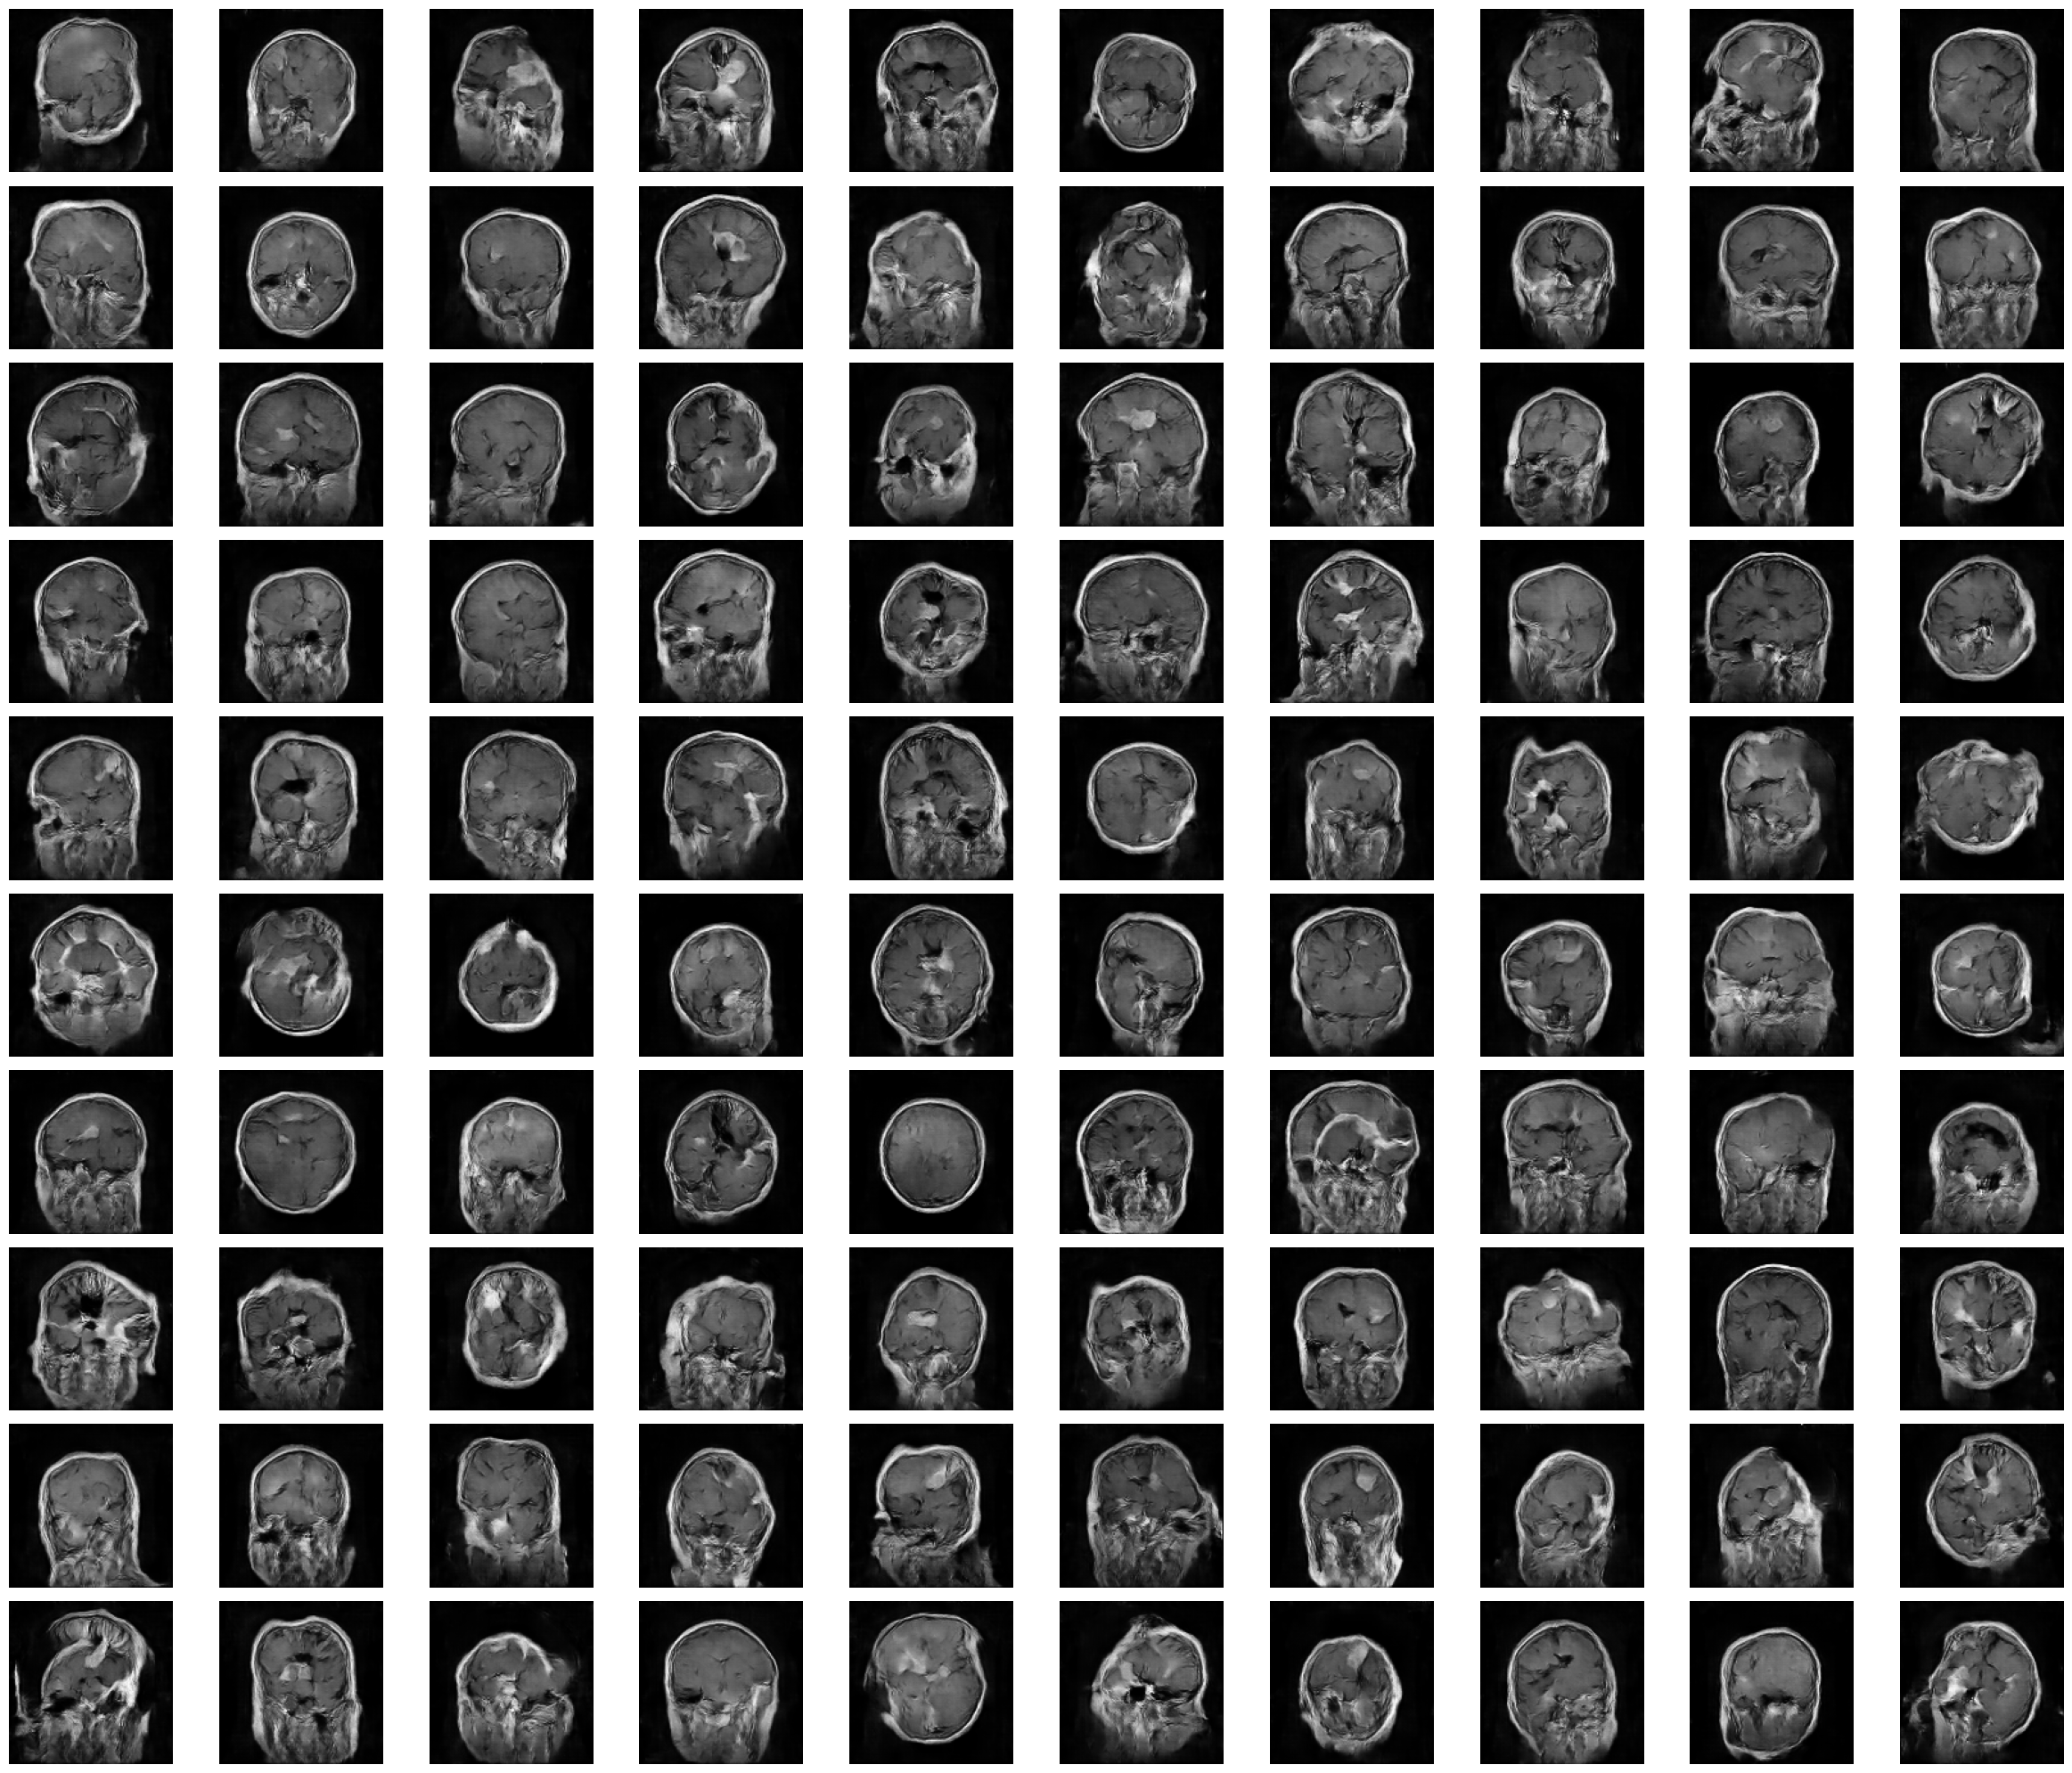

In [ ]:

noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

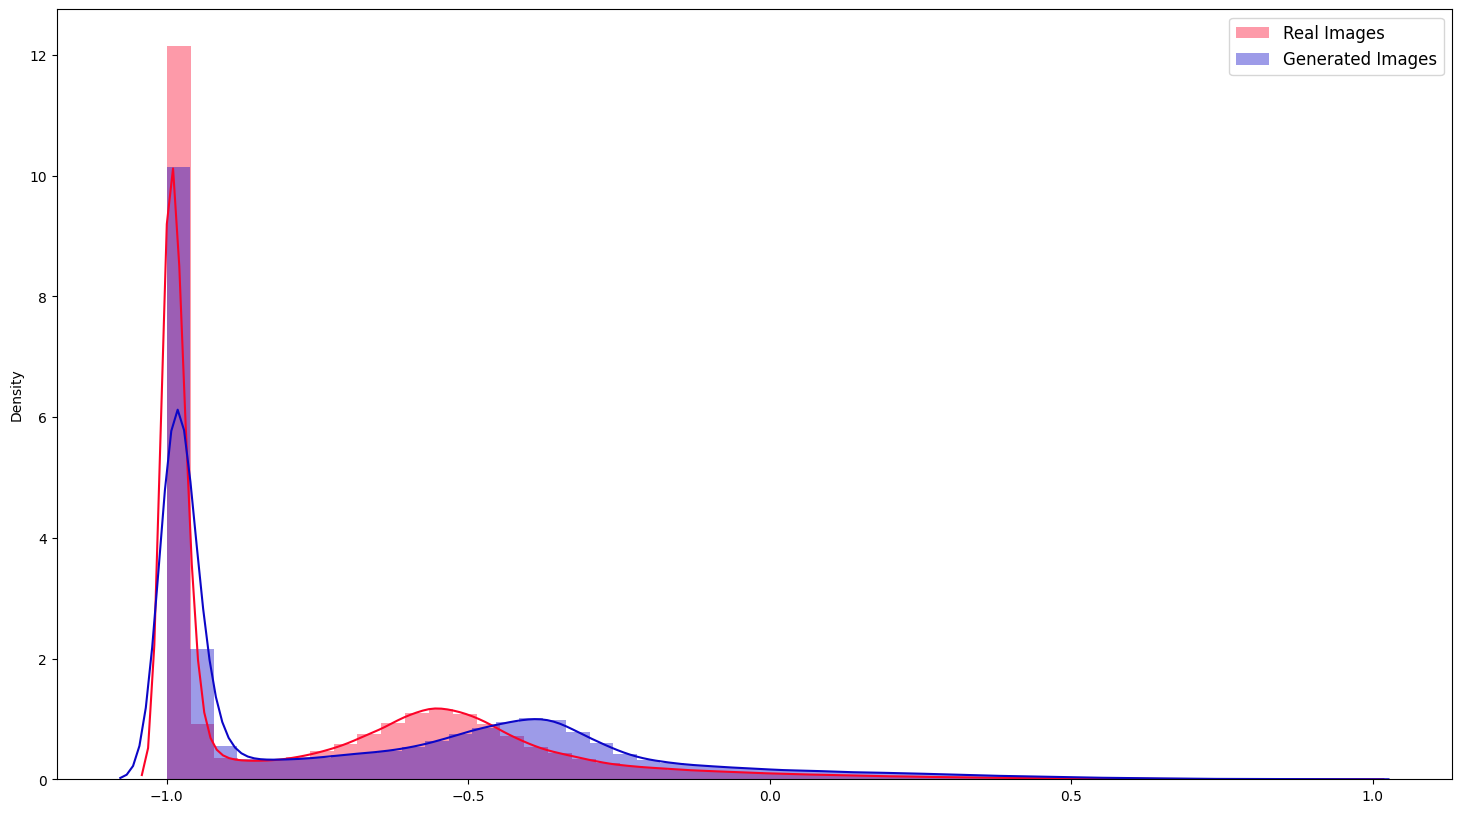

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train_glioma, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()

**FID SCORE**

In [ ]:
from keras.applications import VGG16
from keras.applications.inception_v3 import InceptionV3,preprocess_input
from scipy.linalg import sqrtm


In [ ]:
model = InceptionV3(include_top=False, pooling='avg', weights=None, input_shape=(128, 128, 3))
def calculate_fid(real_images, generated_images):
    """Calculates the FID score between two arrays of real and generated images."""

    # Add an extra dimension to the input data
    real_images = np.expand_dims(real_images, axis=3)
    generated_images = np.expand_dims(generated_images, axis=3)

    # Ensure input data has 3 channels
    if real_images.shape[-1] == 1:
        real_images = np.repeat(real_images, 3, axis=-1)
    if generated_images.shape[-1] == 1:
        generated_images = np.repeat(generated_images, 3, axis=-1)

    # Preprocess the images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Extract features from the real images
    real_features = model.predict(real_images)

    # Extract features from the generated images
    generated_features = model.predict(generated_images)

    # Calculate the mean and covariance of the real and generated features
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_generated, sigma_generated = np.mean(generated_features, axis=0), np.cov(generated_features, rowvar=False)

    # Ensure covariance matrices are positive semi-definite
    sigma_real = np.cov(real_features, rowvar=False) + np.eye(sigma_real.shape[0]) * 1e-6
    sigma_generated = np.cov(generated_features, rowvar=False) + np.eye(sigma_generated.shape[0]) * 1e-6

    # Calculate the sum squared difference between means
    ssd = np.sum((mu_real - mu_generated)**2.0)

    # Calculate the square root of the product of the covariance matrices
    covmean = sqrtm(sigma_real.dot(sigma_generated))

    # Calculate the FID score
    fid = ssd + np.trace(sigma_real + sigma_generated - 2.0 * covmean)

    return fid


In [ ]:
batch_size = generated_images.size // (128 * 128)
generated_images = generated_images.reshape(batch_size, 128, 128)
X_train_meningioma = X_train_meningioma.reshape(X_train_meningioma.shape[0], 128, 128)
print(calculate_fid(X_train_meningioma,generated_images))

1/1 [==============================] - 0s 27ms/step
6.8352780058664945e-12


INCEPTION SCORE

In [ ]:
from scipy.stats import entropy
from keras.models import Model

In [ ]:

# Load the pre-trained Inception V3 base model
base_model = InceptionV3(include_top=False, pooling='avg', input_shape=(128, 128, 3))

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
# Add a classification head to the base model
x = base_model.output
x = Dense(1000, activation='softmax', name='predictions')(x)
inception_model = Model(inputs=base_model.input, outputs=x)

In [ ]:
def calculate_inception_score_for_images(predictions):
    """Calculates the Inception Score for a set of images."""
    scores = []
    for prediction in predictions:
        # Calculate the marginal probability distribution
        marginal_prob = np.mean(prediction, axis=0)

        # Calculate the conditional probability distribution
        conditional_prob = prediction / np.sum(prediction, axis=0, keepdims=True)

        # Add a small constant to prevent numerical instabilities
        conditional_prob = np.clip(conditional_prob, 1e-8, 1.0)

        # Calculate the entropy of the marginal probability distribution
        marginal_entropy = entropy(marginal_prob)

        # Calculate the entropy of the conditional probability distribution
        conditional_entropy = np.mean(entropy(conditional_prob, axis=0))

        # Calculate the Inception Score
        score = np.exp(marginal_entropy - conditional_entropy)
        scores.append(score)

    return np.mean(scores)

In [ ]:
def calculate_inception_score(real_images, generated_images):
    """Calculates the Inception Score between two arrays of real and generated images."""

     # Add an extra dimension to the input data
    real_images = np.expand_dims(real_images, axis=3)
    generated_images = np.expand_dims(generated_images, axis=3)

    # Ensure input data has 3 channels
    if real_images.shape[-1] == 1:
        real_images = np.repeat(real_images, 3, axis=-1)
    if generated_images.shape[-1] == 1:
        generated_images = np.repeat(generated_images, 3, axis=-1)


    # Preprocess the images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)
    # Preprocess the images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Concatenate the real and generated images
    images = np.concatenate((real_images, generated_images), axis=0)

    # Get the predictions from the Inception model
    predictions = inception_model.predict(images)

    # Split the predictions into real and generated parts
    real_predictions = predictions[:real_images.shape[0]]
    generated_predictions = predictions[real_images.shape[0]:]

    # Calculate the Inception Score for real images
    real_score = calculate_inception_score_for_images(real_predictions)

    # Calculate the Inception Score for generated images
    generated_score = calculate_inception_score_for_images(generated_predictions)

    return real_score, generated_score

In [ ]:

print(calculate_inception_score(X_train_meningioma,generated_images))

(300, 128, 128) (32, 128, 128)
11/11 [==============================] - 1s 9ms/step
(0.0011303563159322425, 0.0011303440887967574)
